# Tutorial about Calcephpy

__This tutorial shows how to retrieve the positions of the planets using the python interface of calceph.__

Calceph is a library that computes the positions of the bodies in of our solar system using a ephemeris data file provided by the user. This tutorial provides some examples how to compute and plot the positions of the planets and satellites.

All dates in this tutorial are expressed in the TDB timescale.

In [11]:
from calcephpy import *
print('This tutorial is based on Calceph version=', getversion_str())

This tutorial is based on Calceph version= 3.4.0


We decide to refer to the ephemeris data file as __ephemeris_file__ :

In [12]:
ephemeris_file = "inpop17a_TDB_m100_p100_littleendian.dat"

## Computing the heliocentric position of a body

Calceph can be used to know an object's position at a determined time. This code shows us the heliocentric cartesian position and velocity of Mars on Febuary 14th, 1975(TDB) in the reference frame ICRF. 

In [13]:
from calcephpy import *
import numpy as np

#Open the ephemeris data file
peph = CalcephBin.open(ephemeris_file)

#define the date in the Julian Day TDB system
jd0=2442457           #This is the integer part of the date
dt=0.5E0              #This is the fractional part of the date

#Compute the heliocentric cartesian position and velocity
PV1 = peph.compute_unit(jd0, dt, NaifId.MARS_BARYCENTER, NaifId.SUN, Constants.UNIT_KM+Constants.UNIT_SEC+Constants.USE_NAIFID) 

position = PV1[0:len(PV1)//2]
velocity = PV1[len(PV1)//2: 6]

#Display the result
def printcoord(position, velocity,name):
    print('{0} : \nposition={1}\nvelocity={2}'.format(name,position,velocity))
printcoord(position, velocity,"heliocentric coordinates of Mars in ICRF")

#Close the ephemeris data file
peph.close()

heliocentric coordinates of Mars in ICRF : 
position=[-25688842.695907705, -198724502.192256, -90450959.51187801]
velocity=[24.981845950622507, -0.44026722412630354, -0.8787742654618849]


Cacelph uses the command __NaifId.(objectname)__ to refer to the object you are studying. Here is a [list](https://www.imcce.fr/content/medias/recherche/equipes/asd/calceph/html/python/calceph.naifid.html) of all the objects Calceph knows about.

## Generating a plot using a Numpy array of times

Here an example showing the variation of the Earth-moon's distance.

To study a whole period, we convert it's beginning and ending dates into Julian Days TDB : 

In [14]:
from convertdate import gregorian

debut = gregorian.to_jd(2019, 6, 7)
end = gregorian.to_jd(2020, 6, 8)

This part of the code creates a list of date that Calceph will work with and gives back a list with the distance between the two object every 6h in the period studied.

In [15]:
from calcephpy import*
import numpy as np

peph = CalcephBin.open(ephemeris_file)

time = np.arange(debut, end, 0.25)

jd0=np.floor(time)
dt=time-jd0
   
PV1 = peph.compute_order(jd0, dt, NaifId.MOON, NaifId.EARTH, Constants.UNIT_KM+Constants.UNIT_SEC+Constants.USE_NAIFID,0)
#To calculate the distance, we use the quadratic sum of the coordinates :
distance = np.sqrt(PV1[0]**2+PV1[1]**2+PV1[2]**2) 

peph.close()

Using the previous numpy arrays (time and distance), the Earth-Moon distance is plotted  versus the time between June 7th, 2019 and June 6th, 2020 (TDB): 

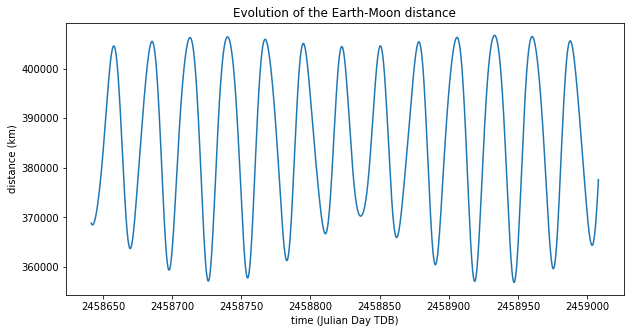

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(time, distance)

plt.xlabel('time (Julian Day TDB)')
plt.ylabel('distance (km)')
plt.title("Evolution of the Earth-Moon distance")

plt.show()

## Generating 3D plots of the internal Solar system

This example computes the heliocentric cartesian coordinates of Mercury, Venus, the Earth and Mars over their orbital period expressed in the reference frame ICRF.
The data are plotted from a orthogonal point of view to the XY-plane of the ICRF.

In [17]:
from calcephpy import*
import numpy as np
import datetime
from convertdate import gregorian
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

date = datetime.datetime.now()
now = gregorian.to_jd(date.year, date.month, date.day)

#Stock the orbital period of each planet of the internal Solar system: 
orbital_period=[0, 89, 226, 366, 688]
peph = CalcephBin.open(ephemeris_file)

x = []
y = []
z = []

#Computing the data :
for j in range (1, 5):
    end = now+orbital_period[j]
    time = np.arange(now, end, 1)

    jd0=np.floor(time)
    dt=time-jd0

    PV= peph.compute_order(jd0, dt, j, NaifId.SUN, Constants.UNIT_AU+Constants.UNIT_SEC+Constants.USE_NAIFID, 0)
    x.append(PV[0])
    y.append(PV[1])
    z.append(PV[2])
peph.close()

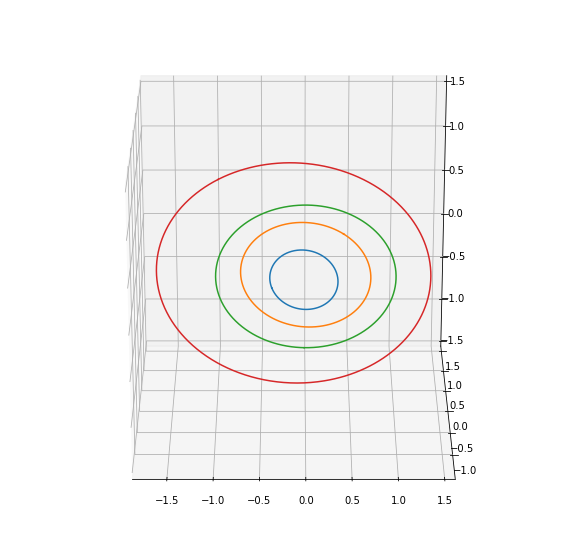

In [18]:
#Create the plot
mpl.rcParams['legend.fontsize'] = 10
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.view_init(azim=-90, elev=23.439291111)
ax.set_zlim3d(-1.5,1.5)

for i in range (4):
    ax.plot(x[i], y[i], z[i])

plt.show()

This code computes the heliocentric cartesian coordinates of the internal Solar system's orbits in the ecliptic frame. The orbits are drawn in the XY- ecliptic plane.

In [19]:
from calcephpy import *
from convertdate import gregorian
import datetime
import numpy as np

date = datetime.datetime.now()
now = gregorian.to_jd(date.year, date.month, date.day)
end = now + 688
orbital_periods=[ 89, 226, 366, 688]

#Matrix correcting the coordinates to adjust to the ecliptic plane :
ICRF_to_ecliptic_matrix = np.array([[9.9999999999999424976605718133711099E-0001, -7.0782797441991966258577759975620460E-0008,
8.0562171469761341523364240742047618E-0008],
[3.2896152138682731422624429703833610E-0008, 9.1748204891850362371387174065077390E-0001,
3.9777718626424950043370378478843413E-0001],
[-1.0207012814778833355760818111989073E-0007, -3.9777718626424456293637635728487189E-0001,
9.1748204891850067645912557598893208E-0001]])

x = []
y = []

#Calculate data from now to the end of a martian arbital period :
peph = CalcephBin.open(ephemeris_file)
for j in range (1, 5):
    t = np.arange(now, end, 1)

    jd0=np.floor(t)
    dt=t-jd0
     
    PV= peph.compute_order(jd0, dt, j, NaifId.SUN, Constants.UNIT_AU+Constants.UNIT_SEC+Constants.USE_NAIFID, 0)
    coordinates = np.array([PV[0],PV[1],PV[2]])
    a= ICRF_to_ecliptic_matrix.dot(coordinates)
    x.append(a[0])
    y.append(a[1])
peph.close()

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import Button, Layout

#Data for the plot's legend
planets_color=['gold', 'grey', 'darkorange', 'dodgerblue', 'firebrick']
planets_name=['Sun','Mercury','Venus','Earth','Mars']
patch = [0]
patch.append(mpatches.Patch(color=planets_color[0], label=planets_name[0]))

#Create the plot : 
def f(Time):
    plt.figure(figsize=(10,10))
    for j in range (4) :
        b = np.intc(abs(Time-now))
        
        plt.scatter(x[j][b],y[j][b], color=planets_color[j+1])      
        plt.plot(x[j][0:orbital_periods[j]], y[j][0:orbital_periods[j]], color=planets_color[j+1])

        p=plt.scatter([0], [0],color='gold', marker='*')
        plt.xlabel('$x_{ecliptic}$ (AU)')
        plt.ylabel('$y_{ecliptic}$ (AU)')
        plt.title("Mercury, Venus, Earth and Mars' orbits")
        patch.append(mpatches.Patch(color=planets_color[j+1], label=planets_name[j+1]))
    plt.legend(handles=[patch[i]for i in range (1,6)], prop= {'size': 11})

#Create the Slider:
layout = widgets.Layout(width='500px', height='50px')
interact(f, Time=widgets.IntSlider(min=now,max=end,step=1,value=now,layout =layout, description='Time (JD)'));

interactive(children=(IntSlider(value=2458655, description='Time (JD)', layout=Layout(height='50px', width='50…

Using the Slider will regenerate the plot with the data of the date you set it's value on.

_To display the interact figure, please run all the cell (Cell -> Run All)._